In [ ]:
!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Uploading the Data (2017)

Link to ISIC-2017_Training_Input: https://drive.google.com/file/d/18dwfVyduqA-7mqt0VwPNhwcQQIhMcJ5p/view?usp=sharing

In [ ]:
downloaded = drive.CreateFile({'id':"18dwfVyduqA-7mqt0VwPNhwcQQIhMcJ5p"})
downloaded.GetContentFile('ISIC-2017_Training_Data.zip') 

Link to ISIC-2017_Ground_Truth (Labels): https://drive.google.com/file/d/1CvNkY4pFtGlb27j7wEW0Ij6oKZ0D1_Ml/view?usp=sharing

In [ ]:
downloaded = drive.CreateFile({'id':"1CvNkY4pFtGlb27j7wEW0Ij6oKZ0D1_Ml"})
downloaded.GetContentFile('ISIC-2017_Training_Part3_GroundTruth.csv') 


Link to ISIC-2017-Validation_Data: https://drive.google.com/file/d/11h1l0lldByDJzTJwlElDggtqQl7NPaXh/view?usp=sharing

In [ ]:
downloaded = drive.CreateFile({'id': "11h1l0lldByDJzTJwlElDggtqQl7NPaXh"})
downloaded.GetContentFile('ISIC-2017_Test_v2_Data.zip')

Link to ISIC-2017_Ground_Truth (Labels for Validation): https://drive.google.com/file/d/1J9DynP9juYlPU-VxShOFCLNHkjTrXyEL/view?usp=sharing

In [ ]:
downloaded = drive.CreateFile({'id':"1J9DynP9juYlPU-VxShOFCLNHkjTrXyEL"})
downloaded.GetContentFile('ISIC-2017_Test_v2_Part3_GroundTruth.csv') 

# Preprocessing

In [ ]:
!cd /content
!unzip ISIC-2017_Training_Data.zip
!rm /content/ISIC-2017_Training_Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: ISIC-2017_Training_Data/ISIC_0012450.jpg  
  inflating: __MACOSX/ISIC-2017_Training_Data/._ISIC_0012450.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0013996.jpg  
  inflating: __MACOSX/ISIC-2017_Training_Data/._ISIC_0013996.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0012489_superpixels.png  
  inflating: __MACOSX/ISIC-2017_Training_Data/._ISIC_0012489_superpixels.png  
  inflating: ISIC-2017_Training_Data/ISIC_0010247.jpg  
  inflating: __MACOSX/ISIC-2017_Training_Data/._ISIC_0010247.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0000054.jpg  
  inflating: __MACOSX/ISIC-2017_Training_Data/._ISIC_0000054.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0011159.jpg  
  inflating: __MACOSX/ISIC-2017_Training_Data/._ISIC_0011159.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0000040.jpg  
  inflating: __MACOSX/ISIC-2017_Training_Data/._ISIC_0000040.jpg  
  inflating: ISIC-2017_Training_Data/ISIC_0013982.jpg  
  inflat

In [ ]:
!cd /content
!unzip ISIC-2017_Test_v2_Data.zip
!rm /content/ISIC-2017_Test_v2_Data.zip

Archive:  ISIC-2017_Test_v2_Data.zip
   creating: ISIC-2017_Test_v2_Data/
  inflating: ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data_metadata.csv  
 extracting: ISIC-2017_Test_v2_Data/ISIC_0012086.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012086_superpixels.png  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012092.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012092_superpixels.png  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012095.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012095_superpixels.png  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012134.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012134_superpixels.png  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012136.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012136_superpixels.png  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012147.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012147_superpixels.png  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012149.jpg  
  inflating: ISIC-2017_Test_v2_Data/ISIC_0012149_superpixels.png 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from tqdm import tqdm

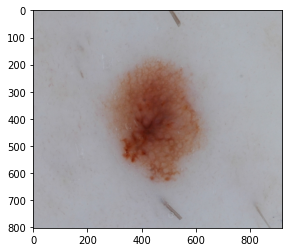

In [ ]:
sample_image = Image.open("/content/ISIC-2017_Training_Data/ISIC_0000486.jpg")
plt.imshow(sample_image)
plt.show()

In [ ]:
from os import listdir
from os.path import isfile

training_images = sorted([f for f in listdir('/content/ISIC-2017_Training_Data/') if f.endswith(".jpg")])
df = pd.read_csv('/content/ISIC-2017_Training_Part3_GroundTruth.csv')
training_labels = df.set_index('image_id').T.to_dict()
print(training_labels)

{'ISIC_0000000': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000001': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000002': {'melanoma': 1.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000003': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000004': {'melanoma': 1.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000006': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000007': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000008': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000009': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000010': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000011': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000012': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000013': {'melanoma': 1.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000014': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000015': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0000016': {'melanoma': 0.0, 'sebo

In [ ]:
test_images = sorted([f for f in listdir('/content/ISIC-2017_Test_v2_Data/') if f.endswith(".jpg")])

df = pd.read_csv(('/content/ISIC-2017_Test_v2_Part3_GroundTruth.csv'))
test_labels = df.set_index('image_id').T.to_dict()
print(test_labels)

{'ISIC_0012086': {'melanoma': 0.0, 'seborrheic_keratosis': 1.0}, 'ISIC_0012092': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0012095': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0012134': {'melanoma': 0.0, 'seborrheic_keratosis': 1.0}, 'ISIC_0012136': {'melanoma': 0.0, 'seborrheic_keratosis': 1.0}, 'ISIC_0012147': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0012149': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0012152': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0012178': {'melanoma': 0.0, 'seborrheic_keratosis': 1.0}, 'ISIC_0012199': {'melanoma': 0.0, 'seborrheic_keratosis': 1.0}, 'ISIC_0012207': {'melanoma': 0.0, 'seborrheic_keratosis': 1.0}, 'ISIC_0012215': {'melanoma': 0.0, 'seborrheic_keratosis': 1.0}, 'ISIC_0012216': {'melanoma': 0.0, 'seborrheic_keratosis': 0.0}, 'ISIC_0012223': {'melanoma': 0.0, 'seborrheic_keratosis': 1.0}, 'ISIC_0012240': {'melanoma': 0.0, 'seborrheic_keratosis': 1.0}, 'ISIC_0012248': {'melanoma': 0.0, 'sebo

In [ ]:
def load_and_crop(image_path, normalized=True):
    image = Image.open(image_path).resize([224,224])
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

x_data = []
y_data = []

for image in tqdm(training_images):
  image_path = "/content/ISIC-2017_Training_Data/" + image
  x_data.append([load_and_crop(image_path)])
  dict_key = image.replace(".jpg", "")
  y_data.append(training_labels[dict_key]["melanoma"])


100%|██████████| 2000/2000 [06:22<00:00,  5.23it/s]


In [ ]:
x_data_arr = np.array(x_data)
y_data_arr = np.array(y_data)

folder = StratifiedKFold(10, shuffle=True)
x_indices = np.arange(0, 2000)
train_indices, val_indices = folder.split(x_indices, y_data_arr).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data_arr[train_indices]
y_train = y_data_arr[train_indices]

x_val = x_data_arr[val_indices]
y_val = y_data_arr[val_indices]

In [ ]:
y_train_non = y_train
y_val_non = y_val

In [ ]:
x_train = np.array([np.squeeze(x) for x in x_train])
y_train = np.eye(2)[y_train.astype(int)]

x_val = np.array([np.squeeze(x) for x in x_val])
y_val = np.eye(2)[y_val.astype(int)]

In [ ]:
print('{} images of class 1 in training'.format(len(y_train_non[y_train_non == 1])))
print('{} images of class 0 in training'.format(len(y_train_non[y_train_non == 0])))
print('{} images of class 1 in validation'.format(len(y_val_non[y_val_non == 1])))
print('{} images of class 0 in validation'.format(len(y_val_non[y_val_non == 0])))

337 images of class 1 in training
1463 images of class 0 in training
37 images of class 1 in validation
163 images of class 0 in validation


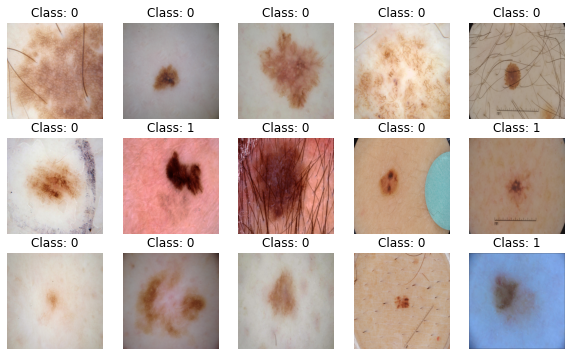

In [ ]:
def plot_examples(batch, label, nrows, ncols):
    plt.figure(figsize=(ncols*2, nrows*2))
    for i in range(batch.shape[0]):
        plt.subplot(nrows, ncols, i+1)
        if batch.shape[-1] == 1: # grayscale iamges
          plt.imshow(batch[i, :, :, 0], cmap='gray')
        else:
          plt.imshow(batch[i, :, :, :])
        plt.title('Class: {}'.format(np.argmax(label[i])))
        plt.axis('off')
    plt.show()

plot_examples(x_train[:15], y_train[:15], 3, 5)

In [ ]:
# Test data processing
x_data1 = []
y_data1 = []

for image in tqdm(test_images):
  image_path = "/content/ISIC-2017_Test_v2_Data/" + image
  x_data1.append([load_and_crop(image_path, 128)])
  dict_key = image.replace(".jpg", "")
  y_data1.append(test_labels[dict_key]["melanoma"])

100%|██████████| 600/600 [05:03<00:00,  1.98it/s]


In [ ]:
x_data_test = np.array(x_data1)
y_data_test = np.array(y_data1)

x_indices = np.arange(0, len(x_data_test))
np.random.shuffle(x_indices)

x_test = x_data_test[x_indices]
y_test = y_data_test[x_indices]

x_test = np.array([np.squeeze(x) for x in x_test])
y_test_non = y_test
y_test = np.eye(2)[y_test.astype(int)]

In [ ]:
print('{} images of class 1 in testing'.format(len(y_test_non[y_test_non == 1])))
print('{} images of class 0 in testing'.format(len(y_test_non[y_test_non == 0])))

117 images of class 1 in testing
483 images of class 0 in testing


In [ ]:
print("Training Data:")
print(y_train.shape)
print(x_train.shape)
print("Validation Data:")
print(y_val.shape)
print(x_val.shape)
print("Test Data:")
print(y_test.shape)
print(x_test.shape)

Training Data:
(1800, 2)
(1800, 224, 224, 3)
Validation Data:
(200, 2)
(200, 224, 224, 3)
Test Data:
(600, 2)
(600, 224, 224, 3)


In [ ]:
x_train_gray = x_train.sum(axis=3)
x_val_gray = x_val.sum(axis=3)
x_test_gray = x_test.sum(axis=3)

x_train_gray = x_train_gray[..., tf.newaxis]
x_val_gray = x_val_gray[..., tf.newaxis]
x_test_gray = x_test_gray[..., tf.newaxis]

x_train_gray = np.array(x_train_gray).reshape(-1, 224, 224, 1)
x_val_gray = np.array(x_val_gray).reshape(-1, 224, 224, 1)
x_test_gray = np.array(x_test_gray).reshape(-1, 224, 224, 1)

print(x_train_gray.shape)

(1800, 224, 224, 1)


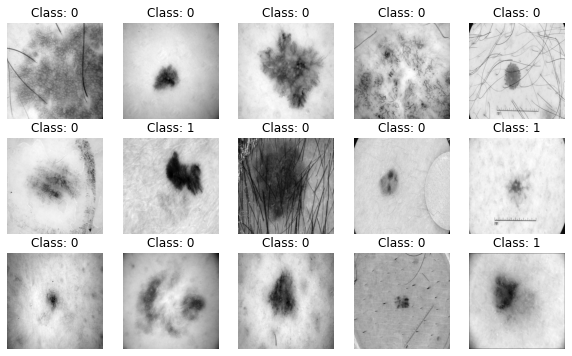

In [ ]:
plot_examples(x_train_gray[:15], y_train[:15], 3, 5)

# Creating the Model for the First Classification Task (Melanoma)

In [ ]:
def focal_loss_color(gamma=2., alpha=0.25):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.math.multiply(y_true, -tf.math.log(model_out))
        weight = tf.math.multiply(y_true, tf.math.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [ ]:
aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90, 
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
model_vgg16_new = tf.keras.applications.VGG16(include_top=True, weights=None, input_shape=(224,224, 1), classes=2)
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
model_vgg16_new.compile(optimizer=opt, loss=focal_loss_color(), metrics=['acc', tf.keras.metrics.AUC()])
model_vgg16_new.evaluate(x=x_test_gray, y=y_test)

19/19 [==============================] - 2s 89ms/step - loss: 0.0434 - acc: 0.1967 - auc: 0.5000


[0.04335551708936691, 0.1966666728258133, 0.5]

In [ ]:
history_vgg16_5 = model_vgg16_new.fit(aug.flow(x_train_gray, y_train, batch_size=64), epochs=15, validation_data=(x_val_gray, y_val))

Epoch 1/15
29/29 [==============================] - 12s 418ms/step - loss: 0.0326 - acc: 0.7917 - auc: 0.8204 - val_loss: 0.0311 - val_acc: 0.8150 - val_auc: 0.8229
Epoch 2/15
29/29 [==============================] - 12s 408ms/step - loss: 0.0318 - acc: 0.8128 - auc: 0.8180 - val_loss: 0.0312 - val_acc: 0.8150 - val_auc: 0.8240
Epoch 3/15
29/29 [==============================] - 12s 411ms/step - loss: 0.0316 - acc: 0.8128 - auc: 0.8207 - val_loss: 0.0318 - val_acc: 0.8150 - val_auc: 0.8250
Epoch 4/15
29/29 [==============================] - 12s 408ms/step - loss: 0.0318 - acc: 0.8128 - auc: 0.8106 - val_loss: 0.0326 - val_acc: 0.8150 - val_auc: 0.8209
Epoch 5/15
29/29 [==============================] - 12s 407ms/step - loss: 0.0319 - acc: 0.8128 - auc: 0.8187 - val_loss: 0.0311 - val_acc: 0.8150 - val_auc: 0.8188
Epoch 6/15
29/29 [==============================] - 12s 408ms/step - loss: 0.0316 - acc: 0.8128 - auc: 0.8100 - val_loss: 0.0313 - val_acc: 0.8150 - val_auc: 0.8276
Epoch 7/15

In [ ]:
test_results_5 = model_vgg16_new.evaluate(x=x_test_gray, y=y_test)

19/19 [==============================] - 1s 62ms/step - loss: 0.0326 - acc: 0.8050 - auc: 0.8020


In [ ]:
total_test_results = [test_results_1, test_results_2, test_results_3, test_results_4, test_results_5]
histories = [history_vgg16_1, history_vgg16_2, history_vgg16_3, history_vgg16_4, history_vgg16_5]

In [ ]:
plt.plot(np.arange(1, 16), histories[0].history['loss'])
plt.plot(np.arange(1, 16), histories[0].history['val_loss'])
plt.legend(["train", "validation"])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

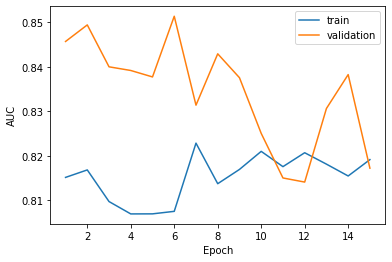

In [ ]:
plt.plot(np.arange(1, 16), histories[0].history['auc'])
plt.plot(np.arange(1, 16), histories[0].history['val_auc'])
plt.legend(["train", "validation"])
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.show()

In [ ]:
total_test_results_arr = np.array(total_test_results)

In [ ]:
avg_test_results = np.average(total_test_results_arr, axis=0)
std_dev_test_results = np.std(total_test_results_arr, axis=0)

In [ ]:
avg_test_results # format is loss, accuracy, auc

array([0.03214365, 0.79900001, 0.81500554])

In [ ]:
std_dev_test_results

array([0.00018729, 0.00489897, 0.00939497])

# Applying Blur

In [ ]:
import skimage.measure
from scipy.signal import convolve

In [ ]:
def make_kernel(kernel_size):
  sigma = 2
  kernel_size = kernel_size
  x = np.linspace(-kernel_size/2, kernel_size/2, kernel_size)
  y = np.linspace(-kernel_size/2, kernel_size/2, kernel_size)
  kernel = np.zeros((kernel_size, kernel_size, 1, 1))

  for i in range(len(x)):
      for j in range(len(y)):
          kernel[i, j, 0, 0] = 1/(2*np.pi*(sigma**2)) * np.exp(-((x[i]*x[i])+(y[j]*y[j]))/(2*sigma*sigma))
  plt.imshow(kernel[:, :, 0, 0])
  plt.show()
  return kernel

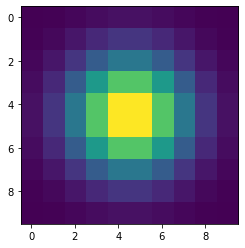

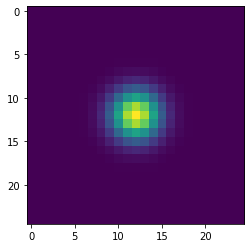

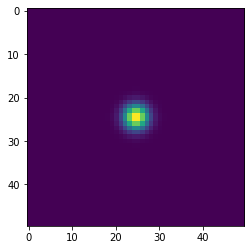

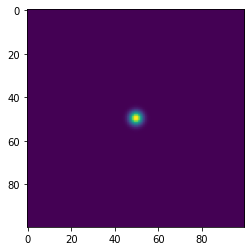

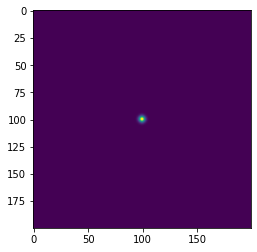

In [ ]:
kernels = [make_kernel(k_size) for k_size in [10, 25, 50, 100, 200]]

In [ ]:
blurred_x_train = [tf.nn.conv2d(x_train_gray, filters=kernel, strides=1, padding="SAME") for kernel in tqdm(kernels)]

100%|██████████| 5/5 [03:09<00:00, 37.93s/it]


In [ ]:
blurred_x_train_ds = [[], [], [], [], []]
for conv, kernel_x_train in enumerate(blurred_x_train):
  for index, im in enumerate(kernel_x_train):
    blurred_x_train_ds[conv].append(skimage.measure.block_reduce(im, (2,2,1), np.average))

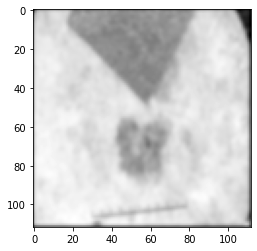

In [ ]:
plt.imshow(blurred_x_train_ds[0][0][:, :, 0], cmap = "gray")


In [ ]:
blurred_x_val = [tf.nn.conv2d(x_val_gray, filters=kernel, strides=1, padding="SAME") for kernel in tqdm(kernels)]

100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


In [ ]:
blurred_x_val_ds = [[], [], [], [], []]
for conv, kernel_x_val in enumerate(blurred_x_val):
  for index, im in enumerate(kernel_x_val):
    blurred_x_val_ds[conv].append(skimage.measure.block_reduce(im, (2,2,1), np.average))

In [ ]:
blurred_x_test = [tf.nn.conv2d(x_test_gray, filters=kernel, strides=1, padding="SAME") for kernel in tqdm(kernels)]

100%|██████████| 5/5 [01:03<00:00, 12.65s/it]


In [ ]:
blurred_x_test_ds = [[], [], [], [], []]
for conv, kernel_x_test in enumerate(blurred_x_test):
  for index, im in enumerate(kernel_x_test):
    blurred_x_test_ds[conv].append(skimage.measure.block_reduce(im, (2,2,1), np.average))

In [ ]:
blurred_x_test_ds= np.array(blurred_x_test_ds)
blurred_x_val_ds = np.array(blurred_x_val_ds)
blurred_x_train_ds = np.array(blurred_x_train_ds)

In [ ]:
def plot_training(history, kernel_size, extension = ""):
  plt.suptitle('Kernel size of {}'.format(kernel_size), fontsize=12)
  plt.subplot(1, 2, 1)
  plt.plot(np.arange(1, 21), history.history['auc' + extension])
  plt.plot(np.arange(1, 21), history.history['val_auc' + extension])
  plt.legend(["training", "testing"])
  plt.title('AUC')
  plt.ylabel('percentage')
  plt.xlabel('epoch')

  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, 21), history.history['loss'])
  plt.plot(np.arange(1, 21), history.history['val_loss'])
  plt.legend(["training", "testing"])
  plt.title('loss')
  plt.ylabel('percentage')
  plt.xlabel('epoch')

  plt.tight_layout()
  plt.show()

In [ ]:
blur_history = []

For Kernel Size 10

In [ ]:
model_vgg16 = tf.keras.applications.VGG16(include_top=True, weights=None, input_shape=(112,112, 1),
                                          classes=2)
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
model_vgg16.compile(optimizer=opt, loss=focal_loss_color(), metrics=['acc', tf.keras.metrics.AUC()])
blur_history.append(model_vgg16.fit(aug.flow(np.array(blurred_x_train_ds[0]), y_train, batch_size=64), epochs=20, validation_data=aug.flow(np.array(blurred_x_val_ds[0]), y_val, batch_size=200)))

Epoch 1/20
29/29 [==============================] - 4s 139ms/step - loss: 0.0333 - acc: 0.8128 - auc_3: 0.8130 - val_loss: 0.0310 - val_acc: 0.8150 - val_auc_3: 0.8491
Epoch 2/20
29/29 [==============================] - 4s 125ms/step - loss: 0.0318 - acc: 0.8128 - auc_3: 0.8190 - val_loss: 0.0307 - val_acc: 0.8150 - val_auc_3: 0.8522
Epoch 3/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0320 - acc: 0.8128 - auc_3: 0.8187 - val_loss: 0.0309 - val_acc: 0.8150 - val_auc_3: 0.8564
Epoch 4/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0314 - acc: 0.8128 - auc_3: 0.8215 - val_loss: 0.0320 - val_acc: 0.8150 - val_auc_3: 0.8504
Epoch 5/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0317 - acc: 0.8128 - auc_3: 0.8136 - val_loss: 0.0309 - val_acc: 0.8150 - val_auc_3: 0.8590
Epoch 6/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0316 - acc: 0.8128 - auc_3: 0.8185 - val_loss: 0.0319 - val_acc: 0.8150 - val_auc_3:

In [ ]:
model_vgg16.evaluate(x=blurred_x_test_ds[0], y=y_test)

19/19 [==============================] - 0s 20ms/step - loss: 0.0321 - acc: 0.8050 - auc_3: 0.8050


[0.03208313137292862, 0.8050000071525574, 0.8050000667572021]

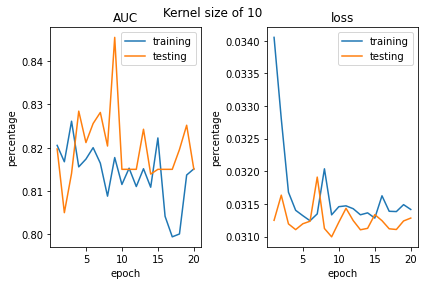

In [ ]:
plot_training(blur_history[0], 10, "_4")

For Kernel Size 25

In [ ]:
model_vgg16 = tf.keras.applications.VGG16(include_top=True, weights=None, input_shape=(112, 112, 1),
                                          classes=2)
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
model_vgg16.compile(optimizer=opt, loss=focal_loss_color(), metrics=['acc', tf.keras.metrics.AUC()])
blur_history.append(model_vgg16.fit(aug.flow(blurred_x_train_ds[1], y_train, batch_size=64), epochs=20, validation_data=aug.flow(blurred_x_val_ds[1], y_val, batch_size=200)))

Epoch 1/20
29/29 [==============================] - 4s 139ms/step - loss: 0.0346 - acc: 0.8100 - auc_7: 0.8101 - val_loss: 0.0313 - val_acc: 0.8150 - val_auc_7: 0.8465
Epoch 2/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0317 - acc: 0.8128 - auc_7: 0.8138 - val_loss: 0.0307 - val_acc: 0.8150 - val_auc_7: 0.8493
Epoch 3/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0325 - acc: 0.8128 - auc_7: 0.8097 - val_loss: 0.0332 - val_acc: 0.8150 - val_auc_7: 0.8344
Epoch 4/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0314 - acc: 0.8128 - auc_7: 0.8220 - val_loss: 0.0309 - val_acc: 0.8150 - val_auc_7: 0.8443
Epoch 5/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0313 - acc: 0.8128 - auc_7: 0.8197 - val_loss: 0.0308 - val_acc: 0.8150 - val_auc_7: 0.8515
Epoch 6/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0316 - acc: 0.8128 - auc_7: 0.8229 - val_loss: 0.0310 - val_acc: 0.8150 - val_auc_7:

In [ ]:
model_vgg16.evaluate(x=blurred_x_test_ds[1], y=y_test)

19/19 [==============================] - 0s 20ms/step - loss: 0.0320 - acc: 0.8050 - auc_7: 0.8050


[0.03198035806417465, 0.8050000071525574, 0.8050000667572021]

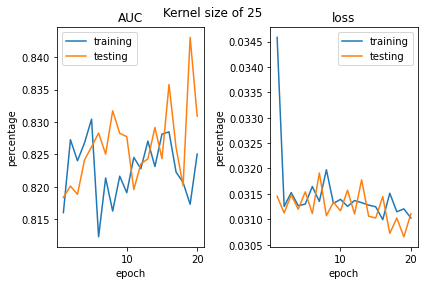

In [ ]:
plot_training(blur_history[1], 25, "_6")

Kernel Size 50

In [ ]:
model_vgg16 = tf.keras.applications.VGG16(include_top=True, weights=None, input_shape=(112, 112, 1),
                                          classes=2)
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
model_vgg16.compile(optimizer=opt, loss=focal_loss_color(), metrics=['acc', tf.keras.metrics.AUC()])
blur_history.append(model_vgg16.fit(aug.flow(blurred_x_train_ds[2], y_train, batch_size=64), epochs=20, validation_data=aug.flow(blurred_x_val_ds[2], y_val, batch_size=200)))

Epoch 1/20
29/29 [==============================] - 4s 140ms/step - loss: 0.0329 - acc: 0.7939 - auc_11: 0.8203 - val_loss: 0.0305 - val_acc: 0.8150 - val_auc_11: 0.8524
Epoch 2/20
29/29 [==============================] - 4s 126ms/step - loss: 0.0317 - acc: 0.8128 - auc_11: 0.8165 - val_loss: 0.0314 - val_acc: 0.8150 - val_auc_11: 0.8538
Epoch 3/20
29/29 [==============================] - 4s 125ms/step - loss: 0.0323 - acc: 0.8128 - auc_11: 0.8229 - val_loss: 0.0307 - val_acc: 0.8150 - val_auc_11: 0.8522
Epoch 4/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0316 - acc: 0.8128 - auc_11: 0.8206 - val_loss: 0.0315 - val_acc: 0.8150 - val_auc_11: 0.8540
Epoch 5/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0315 - acc: 0.8128 - auc_11: 0.8164 - val_loss: 0.0312 - val_acc: 0.8150 - val_auc_11: 0.8556
Epoch 6/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0314 - acc: 0.8128 - auc_11: 0.8181 - val_loss: 0.0313 - val_acc: 0.8150 -

In [ ]:
model_vgg16.evaluate(x=blurred_x_test_ds[2], y=y_test)

19/19 [==============================] - 0s 20ms/step - loss: 0.0320 - acc: 0.8050 - auc_11: 0.8141


[0.03201982006430626, 0.8050000071525574, 0.8141277432441711]

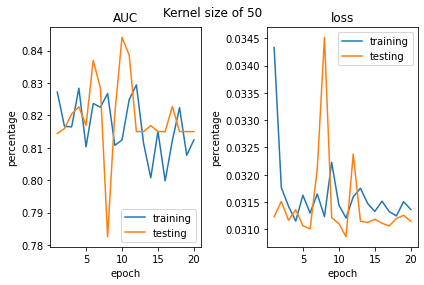

In [ ]:
plot_training(blur_history[2], 50, "_7")

For Kernel Size 100

In [ ]:
model_vgg16 = tf.keras.applications.VGG16(include_top=True, weights=None, input_shape=(112, 112, 1),
                                          classes=2)
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
model_vgg16.compile(optimizer=opt, loss=focal_loss_color(), metrics=['acc', tf.keras.metrics.AUC()])
blur_history.append(model_vgg16.fit(aug.flow(blurred_x_train_ds[3], y_train, batch_size=64), epochs=20, validation_data=aug.flow(blurred_x_val_ds[3], y_val, batch_size=200)))

Epoch 1/20
29/29 [==============================] - 4s 149ms/step - loss: 0.0337 - acc: 0.8106 - auc_15: 0.8142 - val_loss: 0.0306 - val_acc: 0.8150 - val_auc_15: 0.8534
Epoch 2/20
29/29 [==============================] - 4s 126ms/step - loss: 0.0316 - acc: 0.8128 - auc_15: 0.8197 - val_loss: 0.0306 - val_acc: 0.8150 - val_auc_15: 0.8523
Epoch 3/20
29/29 [==============================] - 4s 125ms/step - loss: 0.0314 - acc: 0.8128 - auc_15: 0.8201 - val_loss: 0.0314 - val_acc: 0.8150 - val_auc_15: 0.8488
Epoch 4/20
29/29 [==============================] - 4s 126ms/step - loss: 0.0313 - acc: 0.8128 - auc_15: 0.8235 - val_loss: 0.0306 - val_acc: 0.8150 - val_auc_15: 0.8612
Epoch 5/20
29/29 [==============================] - 4s 125ms/step - loss: 0.0312 - acc: 0.8128 - auc_15: 0.8255 - val_loss: 0.0322 - val_acc: 0.8150 - val_auc_15: 0.8587
Epoch 6/20
29/29 [==============================] - 4s 126ms/step - loss: 0.0317 - acc: 0.8128 - auc_15: 0.8176 - val_loss: 0.0313 - val_acc: 0.8150 -

In [ ]:
model_vgg16.evaluate(x=blurred_x_test_ds[3], y=y_test)

19/19 [==============================] - 0s 20ms/step - loss: 0.0320 - acc: 0.8050 - auc_15: 0.8120


[0.03202894702553749, 0.8050000071525574, 0.8120277523994446]

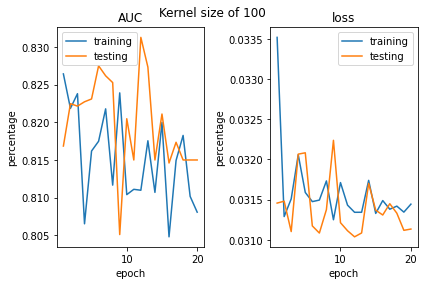

In [ ]:
plot_training(blur_history[3], 100, "_8")

For Kernel Size 200

In [ ]:
model_vgg16 = tf.keras.applications.VGG16(include_top=True, weights=None, input_shape=(112, 112, 1),
                                          classes=2)
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
model_vgg16.compile(optimizer=opt, loss=focal_loss_color(), metrics=['acc', tf.keras.metrics.AUC()])
blur_history.append(model_vgg16.fit(aug.flow(blurred_x_train_ds[4], y_train, batch_size=64), epochs=20, validation_data=aug.flow(blurred_x_val_ds[4], y_val, batch_size=200)))

Epoch 1/20
29/29 [==============================] - 4s 139ms/step - loss: 0.0341 - acc: 0.8128 - auc_4: 0.8224 - val_loss: 0.0310 - val_acc: 0.8150 - val_auc_4: 0.8271
Epoch 2/20
29/29 [==============================] - 4s 125ms/step - loss: 0.0314 - acc: 0.8128 - auc_4: 0.8241 - val_loss: 0.0311 - val_acc: 0.8150 - val_auc_4: 0.8311
Epoch 3/20
29/29 [==============================] - 4s 125ms/step - loss: 0.0323 - acc: 0.8128 - auc_4: 0.8144 - val_loss: 0.0331 - val_acc: 0.8150 - val_auc_4: 0.8252
Epoch 4/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0324 - acc: 0.8128 - auc_4: 0.8166 - val_loss: 0.0311 - val_acc: 0.8150 - val_auc_4: 0.8275
Epoch 5/20
29/29 [==============================] - 4s 124ms/step - loss: 0.0314 - acc: 0.8128 - auc_4: 0.8198 - val_loss: 0.0311 - val_acc: 0.8150 - val_auc_4: 0.8301
Epoch 6/20
29/29 [==============================] - 4s 125ms/step - loss: 0.0314 - acc: 0.8128 - auc_4: 0.8243 - val_loss: 0.0313 - val_acc: 0.8150 - val_auc_4:

In [ ]:
model_vgg16.evaluate(x=blurred_x_test_ds[4], y=y_test)

19/19 [==============================] - 0s 20ms/step - loss: 0.0320 - acc: 0.8050 - auc_4: 0.8074


[0.03195697069168091, 0.8050000071525574, 0.8073999881744385]

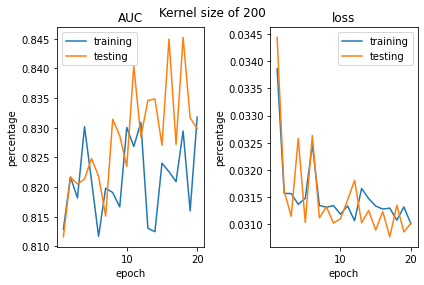

In [ ]:
plot_training(blur_history[4], 200, "_9")

Comparing 

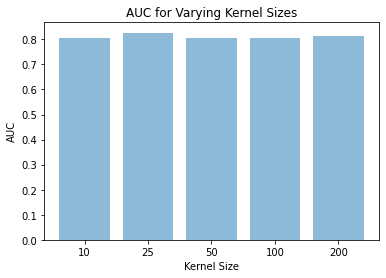

In [ ]:
objects = [10, 25, 50, 100, 200]
y_pos = np.arange(len(objects))
performance = [0.8050, 0.8266, 0.8050, 0.8050, 0.8140]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('AUC')
plt.xlabel('Kernel Size')
plt.title('AUC for Varying Kernel Sizes')

plt.show()

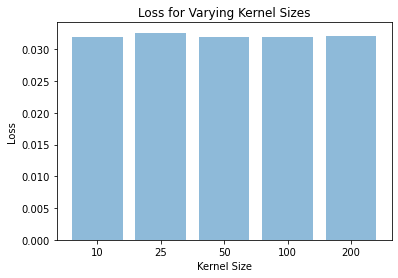

In [ ]:
objects = [10, 25, 50, 100, 200]
y_pos = np.arange(len(objects))
performance = [0.0320, 0.0326, 0.0320, 0.0320, 0.0321]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Loss')
plt.xlabel('Kernel Size')
plt.title('Loss for Varying Kernel Sizes')

plt.show()

# Physical Layer

In [ ]:
from tensorflow.keras.constraints import non_neg
base_model = tf.keras.applications.VGG16(include_top=True, weights=None, classes=2, input_shape=(112, 112, 1))
physical_model = tf.keras.Sequential()
physical_model.add(tf.keras.layers.Conv2D(1, 10, input_shape=(224, 224, 1), padding='same', use_bias=False,
                                 kernel_constraint=non_neg()))
physical_model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
physical_model.add(base_model)
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
physical_model.compile(optimizer=opt, loss=focal_loss_color(), metrics=['acc', tf.keras.metrics.AUC()])
physical_model.evaluate(x=x_test_gray, y=y_test)

19/19 [==============================] - 0s 24ms/step - loss: 0.0435 - acc: 0.1950 - auc_7: 0.5000


[0.04352602735161781, 0.19499999284744263, 0.5]

In [ ]:
history_physical = physical_model.fit(aug.flow(x_train_gray, y_train, batch_size=64), epochs=15, validation_data=(x_val_gray, y_val))

Epoch 1/15
29/29 [==============================] - 7s 233ms/step - loss: 0.0334 - acc: 0.7883 - auc_7: 0.8199 - val_loss: 0.0325 - val_acc: 0.8150 - val_auc_7: 0.7910
Epoch 2/15
29/29 [==============================] - 7s 233ms/step - loss: 0.0316 - acc: 0.8128 - auc_7: 0.8242 - val_loss: 0.0317 - val_acc: 0.8150 - val_auc_7: 0.7929
Epoch 3/15
29/29 [==============================] - 7s 232ms/step - loss: 0.0314 - acc: 0.8128 - auc_7: 0.8246 - val_loss: 0.0315 - val_acc: 0.8150 - val_auc_7: 0.8007
Epoch 4/15
29/29 [==============================] - 7s 233ms/step - loss: 0.0312 - acc: 0.8128 - auc_7: 0.8311 - val_loss: 0.0314 - val_acc: 0.8150 - val_auc_7: 0.8019
Epoch 5/15
29/29 [==============================] - 7s 230ms/step - loss: 0.0315 - acc: 0.8128 - auc_7: 0.8225 - val_loss: 0.0316 - val_acc: 0.8150 - val_auc_7: 0.8019
Epoch 6/15
29/29 [==============================] - 7s 233ms/step - loss: 0.0332 - acc: 0.8128 - auc_7: 0.8144 - val_loss: 0.0319 - val_acc: 0.8150 - val_auc_7:

In [ ]:
physical_results_5 = physical_model.evaluate(x=x_test_gray, y=y_test)

19/19 [==============================] - 0s 24ms/step - loss: 0.0321 - acc: 0.8050 - auc_7: 0.8233


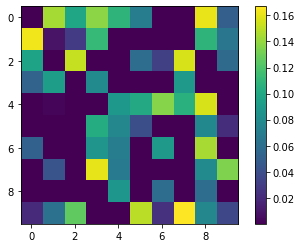

In [ ]:
# with aug 10x10 weights
weights = physical_model.get_weights()
conv = weights[0]
plt.imshow(conv[:, :, 0, 0])
plt.colorbar()
plt.show()

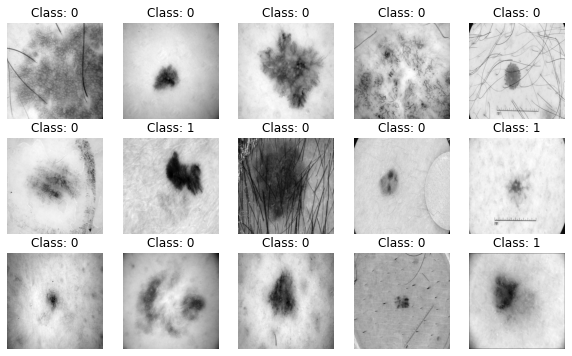

In [ ]:
plot_examples(x_train_gray[:15], y_train[:15], 3, 5) # no blur

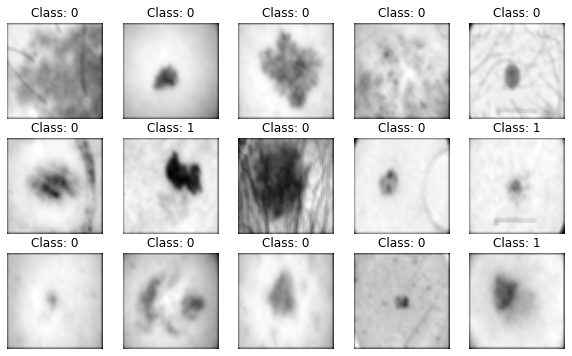

In [ ]:
sample_images = tf.nn.conv2d(x_train_gray[:15], filters=conv, strides=1, padding="SAME")
sample_images = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid")(sample_images)
plot_examples(sample_images, y_train[:15], 3, 5)

In [ ]:
total_results_physical_10 = [physical_results_1, physical_results_2, physical_results_3, physical_results_4, physical_results_5]

In [ ]:
total_results_physical_10_arr = np.array(total_results_physical_10)
avg_results = np.average(total_results_physical_10, axis=0)
std_dev_results = np.std(total_results_physical_10, axis=0)

In [ ]:
avg_results

array([0.03211212, 0.80266668, 0.81331414])

In [ ]:
std_dev_results

array([0.00018593, 0.00466666, 0.00861675])

In [ ]:
# kernel size 25
from tensorflow.keras.constraints import non_neg
base_model = tf.keras.applications.VGG16(include_top=True, weights=None, classes=2, input_shape=(112, 112, 1))
physical_model = tf.keras.Sequential()
physical_model.add(tf.keras.layers.Conv2D(1, 25, input_shape=(224, 224, 1), padding='same', use_bias=False,
                                 kernel_constraint=non_neg()))
physical_model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
physical_model.add(base_model)
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
physical_model.compile(optimizer=opt, loss=focal_loss_color(), metrics=['acc', tf.keras.metrics.AUC()])
physical_model.evaluate(x=x_test_gray, y=y_test)

19/19 [==============================] - 1s 27ms/step - loss: 0.0434 - acc: 0.1950 - auc_8: 0.5000


[0.04336405172944069, 0.19499999284744263, 0.5]

In [ ]:
history_physical = physical_model.fit(aug.flow(x_train_gray, y_train, batch_size=64), epochs=15, validation_data=(x_val_gray, y_val))

Epoch 1/15
29/29 [==============================] - 7s 228ms/step - loss: 0.0329 - acc: 0.7883 - auc_8: 0.8170 - val_loss: 0.0329 - val_acc: 0.8150 - val_auc_8: 0.7908
Epoch 2/15
29/29 [==============================] - 7s 233ms/step - loss: 0.0316 - acc: 0.8128 - auc_8: 0.8262 - val_loss: 0.0357 - val_acc: 0.8150 - val_auc_8: 0.7950
Epoch 3/15
29/29 [==============================] - 7s 234ms/step - loss: 0.0325 - acc: 0.8128 - auc_8: 0.8201 - val_loss: 0.0328 - val_acc: 0.8150 - val_auc_8: 0.7988
Epoch 4/15
29/29 [==============================] - 7s 232ms/step - loss: 0.0314 - acc: 0.8128 - auc_8: 0.8252 - val_loss: 0.0318 - val_acc: 0.8150 - val_auc_8: 0.7976
Epoch 5/15
29/29 [==============================] - 7s 238ms/step - loss: 0.0311 - acc: 0.8128 - auc_8: 0.8303 - val_loss: 0.0315 - val_acc: 0.8150 - val_auc_8: 0.8008
Epoch 6/15
29/29 [==============================] - 7s 232ms/step - loss: 0.0312 - acc: 0.8128 - auc_8: 0.8289 - val_loss: 0.0317 - val_acc: 0.8150 - val_auc_8:

In [ ]:
physical_results_25_5 = physical_model.evaluate(x=x_test_gray, y=y_test)

19/19 [==============================] - 0s 23ms/step - loss: 0.0320 - acc: 0.8050 - auc_6: 0.8079


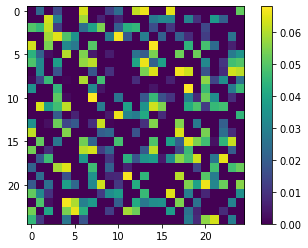

In [ ]:
# with aug 25x25 weights
weights = physical_model.get_weights()
conv = weights[0]
plt.imshow(conv[:, :, 0, 0])
plt.colorbar()
plt.show()

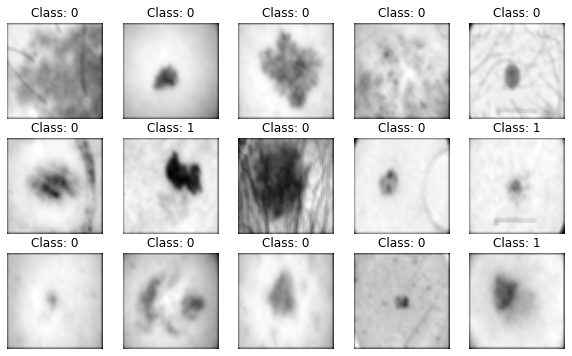

In [ ]:
sample_images = tf.nn.conv2d(x_train_gray[:15], filters=conv, strides=1, padding="SAME")
sample_images = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid")(sample_images)
plot_examples(sample_images, y_train[:15], 3, 5)

In [ ]:
total_results_physical_25 = [physical_results_25_1, physical_results_25_2, 
                             physical_results_25_3, physical_results_25_4, physical_results_25_5]

In [ ]:
total_results_physical_25_arr = np.array(total_results_physical_25)
avg_results = np.average(total_results_physical_25, axis=0)
std_dev_results = np.std(total_results_physical_25, axis=0)

In [ ]:
avg_results

array([0.03223509, 0.80500001, 0.82500553])

In [ ]:
std_dev_results

array([0.00034623, 0.        , 0.00469615])

In [ ]:
# kernel size 50
from tensorflow.keras.constraints import non_neg
base_model = tf.keras.applications.VGG16(include_top=True, weights=None, classes=2, input_shape=(112, 112, 1))
physical_model = tf.keras.Sequential()
physical_model.add(tf.keras.layers.Conv2D(1, 50, input_shape=(224, 224, 1), padding='same', use_bias=False,
                                 kernel_constraint=non_neg()))
physical_model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
physical_model.add(base_model)
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
physical_model.compile(optimizer=opt, loss=focal_loss_color(), metrics=['acc', tf.keras.metrics.AUC()])
physical_model.evaluate(x=x_test_gray, y=y_test)

19/19 [==============================] - 2s 92ms/step - loss: 0.0436 - acc: 0.1950 - auc_18: 0.5000


[0.04355943575501442, 0.19499999284744263, 0.5]

In [ ]:
history_physical = physical_model.fit(aug.flow(x_train_gray, y_train, batch_size=64), epochs=15, validation_data=(x_val_gray, y_val))

Epoch 1/15
29/29 [==============================] - 12s 403ms/step - loss: 0.0357 - acc: 0.7917 - auc_18: 0.8077 - val_loss: 0.0319 - val_acc: 0.8150 - val_auc_18: 0.7980
Epoch 2/15
29/29 [==============================] - 12s 402ms/step - loss: 0.0316 - acc: 0.8128 - auc_18: 0.8260 - val_loss: 0.0325 - val_acc: 0.8150 - val_auc_18: 0.7968
Epoch 3/15
29/29 [==============================] - 12s 402ms/step - loss: 0.0317 - acc: 0.8128 - auc_18: 0.8151 - val_loss: 0.0315 - val_acc: 0.8150 - val_auc_18: 0.8001
Epoch 4/15
29/29 [==============================] - 12s 402ms/step - loss: 0.0313 - acc: 0.8128 - auc_18: 0.8247 - val_loss: 0.0320 - val_acc: 0.8150 - val_auc_18: 0.7976
Epoch 5/15
29/29 [==============================] - 12s 402ms/step - loss: 0.0313 - acc: 0.8128 - auc_18: 0.8280 - val_loss: 0.0339 - val_acc: 0.8150 - val_auc_18: 0.7994
Epoch 6/15
29/29 [==============================] - 12s 402ms/step - loss: 0.0315 - acc: 0.8128 - auc_18: 0.8250 - val_loss: 0.0314 - val_acc: 0.

In [ ]:
physical_results_50_5 = physical_model.evaluate(x=x_test_gray, y=y_test)

19/19 [==============================] - 2s 92ms/step - loss: 0.0320 - acc: 0.8050 - auc_5: 0.8253


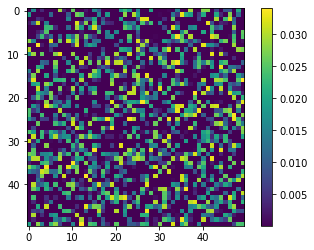

In [ ]:
# with aug 50x50 weights
weights = physical_model.get_weights()
conv = weights[0]
plt.imshow(conv[:, :, 0, 0])
plt.colorbar()
plt.show()

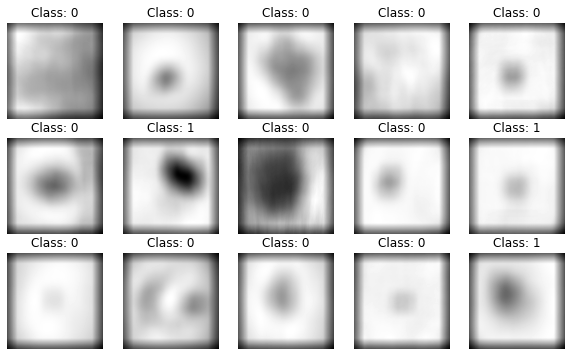

In [ ]:
sample_images = tf.nn.conv2d(x_train_gray[:15], filters=conv, strides=1, padding="SAME")
sample_images = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid")(sample_images)
plot_examples(sample_images, y_train[:15], 3, 5)

In [ ]:
total_results_physical_50 = [physical_results_50_1, physical_results_50_2, physical_results_50_3,
                             physical_results_50_4, physical_results_50_5]

In [ ]:
total_results_physical_50_arr = np.array(total_results_physical_50)
avg_results = np.average(total_results_physical_50_arr, axis=0)
std_dev_results = np.std(total_results_physical_50_arr, axis=0)

In [ ]:
avg_results

array([0.03219032, 0.80500001, 0.82313   ])

In [ ]:
std_dev_results

array([0.00062609, 0.        , 0.00358106])

In [ ]:
from tensorflow.keras.constraints import non_neg
base_model = tf.keras.applications.VGG16(include_top=True, weights=None, classes=2, input_shape=(112, 112, 1))
physical_model = tf.keras.Sequential()
physical_model.add(tf.keras.layers.Conv2D(1, 100, input_shape=(224, 224, 1), padding='same', use_bias=False,
                                 kernel_constraint=non_neg()))
physical_model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
physical_model.add(base_model)
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
physical_model.compile(optimizer=opt, loss=focal_loss_color(), metrics=['acc', tf.keras.metrics.AUC()])
physical_model.evaluate(x=x_test_gray, y=y_test)

19/19 [==============================] - 6s 294ms/step - loss: 0.0435 - acc: 0.1950 - auc_15: 0.5000


[0.04345301166176796, 0.19499999284744263, 0.5]

In [ ]:
history_physical = physical_model.fit(aug.flow(x_train_gray, y_train, batch_size=64), epochs=15, validation_data=(x_val_gray, y_val))

Epoch 1/15
29/29 [==============================] - 35s 1s/step - loss: 0.0334 - acc: 0.7706 - auc_15: 0.8198 - val_loss: 0.0316 - val_acc: 0.8150 - val_auc_15: 0.7985
Epoch 2/15
29/29 [==============================] - 34s 1s/step - loss: 0.0318 - acc: 0.8128 - auc_15: 0.8215 - val_loss: 0.0324 - val_acc: 0.8150 - val_auc_15: 0.7991
Epoch 3/15
29/29 [==============================] - 35s 1s/step - loss: 0.0315 - acc: 0.8128 - auc_15: 0.8246 - val_loss: 0.0315 - val_acc: 0.8150 - val_auc_15: 0.7986
Epoch 4/15
29/29 [==============================] - 34s 1s/step - loss: 0.0320 - acc: 0.8128 - auc_15: 0.8254 - val_loss: 0.0327 - val_acc: 0.8150 - val_auc_15: 0.8050
Epoch 5/15
29/29 [==============================] - 34s 1s/step - loss: 0.0319 - acc: 0.8128 - auc_15: 0.8204 - val_loss: 0.0320 - val_acc: 0.8150 - val_auc_15: 0.7984
Epoch 6/15
29/29 [==============================] - 34s 1s/step - loss: 0.0314 - acc: 0.8128 - auc_15: 0.8178 - val_loss: 0.0317 - val_acc: 0.8150 - val_auc_15:

In [ ]:
physical_results_100_5 = physical_model.evaluate(x=x_test_gray, y=y_test)

19/19 [==============================] - 6s 292ms/step - loss: 0.0321 - acc: 0.8050 - auc_8: 0.8274


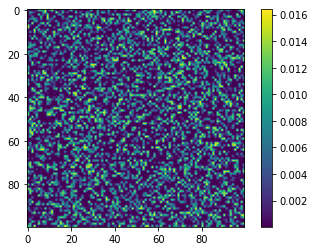

In [ ]:
# with aug 100x100 weights
weights = physical_model.get_weights()
conv = weights[0]
plt.imshow(conv[:, :, 0, 0])
plt.colorbar()
plt.show()

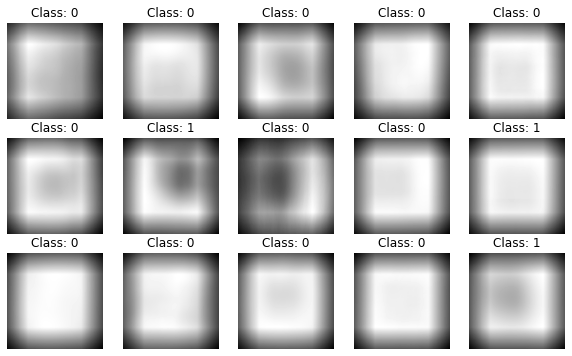

In [ ]:
sample_images = tf.nn.conv2d(x_train_gray[:15], filters=conv, strides=1, padding="SAME")
sample_images = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid")(sample_images)
plot_examples(sample_images, y_train[:15], 3, 5)

In [ ]:
total_results_physical_100 = [physical_results_100_1, physical_results_100_2, physical_results_100_3,
                              physical_results_100_4, physical_results_100_5]

In [ ]:
total_results_physical_100_arr = np.array(total_results_physical_100)
avg_results = np.average(total_results_physical_100_arr, axis=0)
std_dev_results = np.std(total_results_physical_100_arr, axis=0)

In [ ]:
avg_results

array([0.03198414, 0.80500001, 0.8265628 ])

In [ ]:
std_dev_results

array([0.00016502, 0.        , 0.00207038])

In [ ]:
from tensorflow.keras.constraints import non_neg
base_model = tf.keras.applications.VGG16(include_top=True, weights=None, classes=2, input_shape=(112, 112, 1))
physical_model = tf.keras.Sequential()
physical_model.add(tf.keras.layers.Conv2D(1, 200, input_shape=(224, 224, 1), padding='same', use_bias=False,
                                 kernel_constraint=non_neg()))
physical_model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
physical_model.add(base_model)
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
physical_model.compile(optimizer=opt, loss=focal_loss_color(), metrics=['acc', tf.keras.metrics.AUC()])
physical_model.evaluate(x=x_test_gray, y=y_test)

19/19 [==============================] - 20s 1s/step - loss: 0.0432 - acc: 0.8050 - auc_4: 0.5000


[0.043237458914518356, 0.8050000071525574, 0.5]

In [ ]:
history_physical = physical_model.fit(aug.flow(x_train_gray, y_train, batch_size=64), epochs=15, validation_data=(x_val_gray, y_val))

Epoch 1/15
29/29 [==============================] - 124s 4s/step - loss: 0.0379 - acc: 0.7894 - auc_4: 0.8029 - val_loss: 0.0308 - val_acc: 0.8150 - val_auc_4: 0.8638
Epoch 2/15
29/29 [==============================] - 124s 4s/step - loss: 0.0314 - acc: 0.8128 - auc_4: 0.8280 - val_loss: 0.0302 - val_acc: 0.8150 - val_auc_4: 0.8636
Epoch 3/15
29/29 [==============================] - 124s 4s/step - loss: 0.0316 - acc: 0.8128 - auc_4: 0.8189 - val_loss: 0.0304 - val_acc: 0.8150 - val_auc_4: 0.8624
Epoch 4/15
29/29 [==============================] - 126s 4s/step - loss: 0.0322 - acc: 0.8128 - auc_4: 0.8151 - val_loss: 0.0306 - val_acc: 0.8150 - val_auc_4: 0.8622
Epoch 5/15
29/29 [==============================] - 124s 4s/step - loss: 0.0314 - acc: 0.8128 - auc_4: 0.8241 - val_loss: 0.0304 - val_acc: 0.8150 - val_auc_4: 0.8623
Epoch 6/15
29/29 [==============================] - 124s 4s/step - loss: 0.0312 - acc: 0.8128 - auc_4: 0.8276 - val_loss: 0.0306 - val_acc: 0.8150 - val_auc_4: 0.859

In [ ]:
physical_results_200_5 = physical_model.evaluate(x=x_test_gray, y=y_test)

19/19 [==============================] - 20s 1s/step - loss: 0.0321 - acc: 0.8050 - auc_4: 0.8276


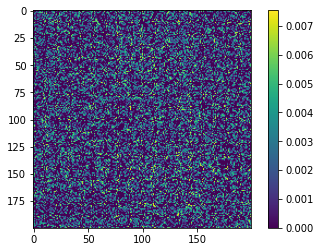

In [ ]:
# with aug 200x200 weights
weights = physical_model.get_weights()
conv = weights[0]
plt.imshow(conv[:, :, 0, 0])
plt.colorbar()
plt.show()

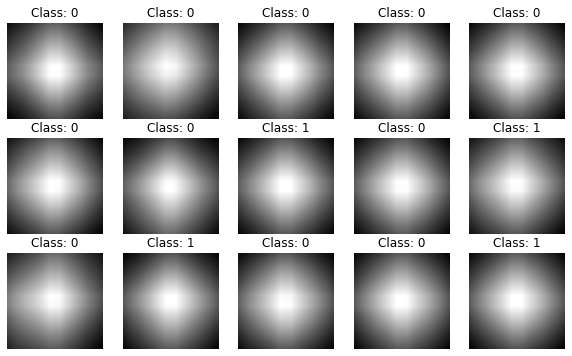

In [ ]:
sample_images = tf.nn.conv2d(x_train_gray[:15], filters=conv, strides=1, padding="SAME")
sample_images = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid")(sample_images)
plot_examples(sample_images, y_train[:15], 3, 5)

In [ ]:
total_results_physical_200 = [physical_results_200_1, physical_results_200_2, physical_results_200_3,
                              physical_results_200_4, physical_results_200_5]

In [ ]:
total_results_physical_200_arr = np.array(total_results_physical_200)
avg_results = np.average(total_results_physical_200_arr, axis=0)
std_dev_results = np.std(total_results_physical_200_arr, axis=0)

In [ ]:
avg_results

array([0.03199359, 0.80500001, 0.82693278])

In [ ]:
std_dev_results

array([0.000104  , 0.        , 0.00215063])

# Comparing Images

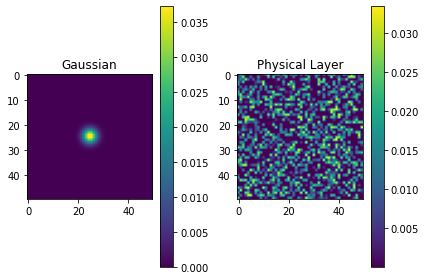

In [ ]:
sigma = 2
kernel_size = 50
x = np.linspace(-kernel_size/2, kernel_size/2, kernel_size)
y = np.linspace(-kernel_size/2, kernel_size/2, kernel_size)
kernel = np.zeros((kernel_size, kernel_size, 1, 1))

for i in range(len(x)):
    for j in range(len(y)):
        kernel[i, j, 0, 0] = 1/(2*np.pi*(sigma**2)) * np.exp(-((x[i]*x[i])+(y[j]*y[j]))/(2*sigma*sigma))
plt.subplot(1, 2, 1)
plt.imshow(kernel[:, :, 0, 0])
plt.colorbar()
plt.title("Gaussian")

plt.subplot(1, 2, 2)
plt.imshow(conv[:, :, 0, 0])
plt.colorbar()
plt.title("Physical Layer")

plt.tight_layout()
plt.show()

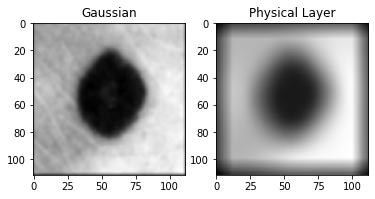

In [ ]:
sample_images = tf.nn.conv2d(x_train_gray[0:25], filters=conv, strides=1, padding="SAME")
sample_images = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid")(sample_images)
plt.subplot(1, 2, 2)
plt.imshow(sample_images[0][:, :, 0], cmap = "gray")
plt.title("Physical Layer")

plt.subplot(1, 2, 1)
plt.imshow(blurred_x_train_ds[2][0][:, :, 0], cmap = "gray")
plt.title("Gaussian")
plt.show()

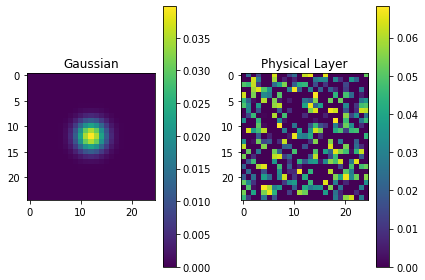

In [ ]:
sigma = 2
kernel_size = 25
x = np.linspace(-kernel_size/2, kernel_size/2, kernel_size)
y = np.linspace(-kernel_size/2, kernel_size/2, kernel_size)
kernel = np.zeros((kernel_size, kernel_size, 1, 1))

for i in range(len(x)):
    for j in range(len(y)):
        kernel[i, j, 0, 0] = 1/(2*np.pi*(sigma**2)) * np.exp(-((x[i]*x[i])+(y[j]*y[j]))/(2*sigma*sigma))
plt.subplot(1, 2, 1)
plt.imshow(kernel[:, :, 0, 0])
plt.colorbar()
plt.title("Gaussian")

plt.subplot(1, 2, 2)
plt.imshow(conv[:, :, 0, 0])
plt.colorbar()
plt.title("Physical Layer")

plt.tight_layout()
plt.show()

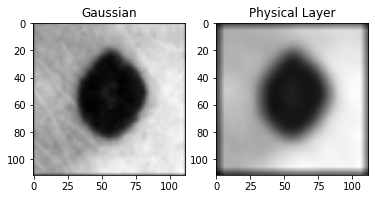

In [ ]:
sample_images = tf.nn.conv2d(x_train_gray[0:25], filters=conv, strides=1, padding="SAME")
sample_images = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid")(sample_images)
plt.subplot(1, 2, 2)
plt.imshow(sample_images[0][:, :, 0], cmap = "gray")
plt.title("Physical Layer")

plt.subplot(1, 2, 1)
plt.imshow(blurred_x_train_ds[1][0][:, :, 0], cmap = "gray")
plt.title("Gaussian")
plt.show()

In [ ]:
from tensorflow.keras.constraints import non_neg
base_model = tf.keras.applications.VGG16(include_top=True, weights=None, classes=2, input_shape=(112, 112, 1))
physical_model = tf.keras.Sequential()
physical_model.add(tf.keras.layers.Conv2D(1, 10, input_shape=(224, 224, 1), padding='same', use_bias=False,
                                 kernel_constraint=non_neg()))
physical_model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
physical_model.add(base_model)
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
physical_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.AUC()])
physical_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 1)       100       
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 1)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 2)                 50381506  
Total params: 50,381,606
Trainable params: 50,381,606
Non-trainable params: 0
_________________________________________________________________


In [ ]:
base_model = tf.keras.applications.VGG16(include_top=True, weights=None, classes=2, input_shape=(112, 112, 1))
opt = tf.keras.optimizers.Adam(lr=0.0001) # could also use Adam as our optimizer
base_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.AUC()])
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0     